<a href="https://colab.research.google.com/github/CrzPhil/IN3063-Coursework/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IN3063 - Coursework

## Libraries

In [286]:
import math
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

## Sigmoid & ReLU

- By Aymen
- Reference:
    - https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
    - https://www.sharpsightlabs.com/blog/numpy-relu/
    - Lab 6

In [287]:
# Forward pass for Sigmoid
def forward_sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Backward pass for Sigmoid
def backward_sigmoid(x):
    return forward_sigmoid(x) * (1 - forward_sigmoid(x))

In [288]:
# Forward pass for ReLU
def forward_relu(x):
    return np.maximum(0, x)

# Backward pass for ReLU
def backward_relu(x):
    return np.where(x > 0, 1, 0)

## Softmax

- By Aymen
- Using the Numpy version
- Reference:
    - https://towardsdatascience.com/softmax-function-simplified-714068bf8156
    - https://en.wikipedia.org/wiki/Softmax_function
    - https://www.sharpsightlabs.com/blog/numpy-softmax/

In [289]:
# Forward pass for Softmax
def forward_softmax(x):
    exponential = np.exp(x - np.max(x))
    return exponential / exponential.sum() # calculates softmax probability

# Backward pass for Softmax
def backward_softmax(x):
    return np.reshape(forward_softmax(x) * (1 - forward_softmax(x)), (1, -1)) # computes gradient of softmax

# Testing:
x = np.array([100.0, 2000.0, 300.0]) # large numbers
print("Forward pass result:", forward_softmax(x))
print("Backward pass result:", backward_softmax(x))
print ("\n")

x = np.array([1.0, 2.0, 3.0]) # small numbers
print("Forward pass result:", forward_softmax(x))
print("Backward pass result:", backward_softmax(x))

Forward pass result: [0. 1. 0.]
Backward pass result: [[0. 0. 0.]]


Forward pass result: [0.09003057 0.24472847 0.66524096]
Backward pass result: [[0.08192507 0.18483645 0.22269543]]


## Dropout

- By Adam
- References
  - Lecture 7
  - https://stackoverflow.com/questions/70836518/typeerror-bad-operand-type-for-unary-list-python
  - https://stackoverflow.com/questions/25854380/enforce-arguments-to-a-specific-list-of-values

In [290]:
'''
Valid value structure constants.
They're defined here so they aren't recreated every time the function is ran.
'''
ACTIVATION_FUNCTIONS = {
    "sigmoid": [forward_sigmoid, backward_sigmoid],
    "relu": [forward_relu, backward_relu],
    "softmax": [forward_softmax, backward_softmax]
}

VALID_DIRECTIONS = ["forward", "backward"]

'''
Dropout function
    x = input vector
    probability is a float between 0.0 and 1.0
    activation_function is a string that corresponds to one of the key values above
        determines which activation function to use
    direction is a string that corresponds to one of the array values above
        determines whether to use a forward or backward pass activation function
    inverted is a boolean
        determines whether or not use inverted dropout
    train is a boolean
        determines whether to train or test
'''
def dropout(x, probability, activation_function, direction, inverted, train):
    if activation_function not in ACTIVATION_FUNCTIONS.keys():
        raise ValueError(f"Activation function must be one of {ACTIVATION_FUNCTIONS.keys()}")

    if direction not in VALID_DIRECTIONS:
        raise ValueError(f"Direction must be one of {VALID_DIRECTIONS}")

    value_index = 0 if direction == "forward" else 1

    H1 = ACTIVATION_FUNCTIONS[activation_function][value_index](x)
    mask = (np.random.rand(*H1.shape) < probability)

    if inverted:
        return H1 * (mask / probability) if train else H1
    else:
        return H1 * mask if train else H1 * probability

# Testing the function
#     Starting by defining x
x = np.array([2.0, 4.0, 7.0, 8.0])

#     Training
H1_dropped = dropout(x, 0.5, "sigmoid", "forward", False, True)
print(H1_dropped)

#     Testing
H1_dropped = dropout(x, 0.5, "sigmoid", "forward", False, False)
print(H1_dropped)

#     Training, inverted
H1_dropped = dropout(x, 0.5, "sigmoid", "forward", True, True)
print(H1_dropped)

#     Testing, inverted
H1_dropped = dropout(x, 0.5, "sigmoid", "forward", True, True)
print(H1_dropped)

[0.88079708 0.98201379 0.         0.99966465]
[0.44039854 0.4910069  0.49954447 0.49983232]
[0.        0.        1.9981779 1.9993293]
[0.        0.        1.9981779 0.       ]


## Optimizers
- By Taha  
References:
  - Lecture 8
  - Lecture 9
  - https://www.kdnuggets.com/2020/12/optimization-algorithms-neural-networks.html
  - http://deeplearning.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/
  - https://keras.io/api/optimizers/sgd/
  - https://towardsdatascience.com/neural-network-optimizers-from-scratch-in-python-af76ee087aab

In [291]:
class SGDOptimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        # initialises the learning rate with parameter inputed by the user 

    def update(self, parameter, gradient):
        return parameter - self.learning_rate * gradient
        # updates the parameter according to the learning rate (from init function) and gradient
        
class SGDMomentumOptimizer:
    def __init__(self, learning_rate, momentum):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocities = {}
        # initialises the parameters

    def update(self, parameter, gradient):
        param_id = (parameter.shape, parameter.dtype)
        # gives each parameter a unique identifier

        # Initialise the velocity for this parameter if it hasn't been initialized yet
        if param_id not in self.velocities:
            # check if the velocity for the parameter has been initialised, if not it gets initialised with 0's 
            self.velocities[param_id] = np.zeros_like(parameter)

        # this is where the velocities get updated using the formula below
        # the momentum determines how much of the velocity is retained 
        # the current gradient also has an effect on the updated velocities
        self.velocities[param_id] = self.momentum * self.velocities[param_id] + self.learning_rate * gradient
        return parameter - self.velocities[param_id]

## Neural Network
References:
  - Lecture 6
  - Lecture 7
  - https://towardsdatascience.com/step-by-step-guide-to-building-your-own-neural-network-from-scratch-df64b1c5ab6e
  - https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd

Loading the Dataset 

To load the MNIST dataset, we created a function that parses the files in the way described in the resource http://yann.lecun.com/exdb/mnist/. The key thing to note is that the bytes are unsigned and in big endian, hence the use of the format `>HBB` in the `struct.unpack` call, as per the documentation (https://docs.python.org/3/library/struct.html#byte-order-size-and-alignment). 

In [292]:
# Reading the MNIST dataset as per http://yann.lecun.com/exdb/mnist/
import os
import struct

def read_idx(filename):
    with open(filename, 'rb') as file:
        # Read two bytes (big endian and unsigned)
        zero, data_type, dims = struct.unpack('>HBB', file.read(4))
        # Four byte integer big endian
        shape = tuple(struct.unpack('>I', file.read(4))[0] for d in range(dims))
        return np.frombuffer(file.read(), dtype=np.uint8).reshape(shape)

def load_mnist(path):
    # Paths to the files
    train_images_path = os.path.join(path, 'train-images-idx3-ubyte')
    train_labels_path = os.path.join(path, 'train-labels-idx1-ubyte')
    test_images_path = os.path.join(path, 't10k-images-idx3-ubyte')
    test_labels_path = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Loading the datasets
    train_images = read_idx(train_images_path)
    train_labels = read_idx(train_labels_path)
    test_images = read_idx(test_images_path)
    test_labels = read_idx(test_labels_path)

    return train_images, train_labels, test_images, test_labels

In [293]:
# labels are just an array of 6000 elements; we need them as arrays of 10 elements
# 10 elements because MNIST can be digits 0-9; we need all elements to be 0 except
# the correct element, which will be 1.
def one_hot_encode(labels):
    one_hot_labels = np.zeros((len(labels), 10))
    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels

In [294]:
class NeuralNet:
    def __init__(
        self,
        activation_function,
        neurons: list,
        learning_rate,
        optimizer,
        dropout_prob=None,
    ):
        """
        Initialises a new instance of the NeuralNet class.

        Parameters:
        activation_function (func): The activation function to be used in the network layers.
                                    The function is used in all layers.
        neurons (list of int): The number of neurons in each layer. This should be a list where each element represents
                                the number of neurons in the respective layer of the network (input not included, output included and should be 10 for MNIST)
        learning_rate (float): Number between 0-1 specifying the learning rate of the NN.
        optimizer (func): Which optimizer to use (momentum / no momentum).
        dropout_prob (float): Optional- if specified, use dropout with this probability between 0-1.
                                Otherwise, no dropout.
        """

        ACTIVATION_FUNCTIONS = {
            "sigmoid": [forward_sigmoid, backward_sigmoid],
            "relu": [forward_relu, backward_relu],
        }

        self.activation_function = ACTIVATION_FUNCTIONS[activation_function]
        self.neurons = neurons
        self.layers = len(self.neurons)
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.dropout_prob = dropout_prob
        # Will be initialised once features are known
        self.weights = []
        self.biases = []

    def init_weights_and_biases(self, input_features):
        # Initialise weights and biases based on the layers, neurons, and input features
        # Fully connected through weights
        for i in range(self.layers):
            if i == 0:
                # input layer matrix needs to have as many columns as neurons
                layer_weights = np.random.randn(self.neurons[i], input_features) * 0.01
            else:
                # weights matrix with a column for each node in the previous layer and a row for each node in the current layer
                layer_weights = (
                    np.random.randn(self.neurons[i], self.neurons[i - 1]) * 0.01
                )
            layer_bias = np.zeros((self.neurons[i], 1))
            self.weights.append(layer_weights)
            self.biases.append(layer_bias)

    def forward_pass(self, X, is_training=True):
        activations = [X]
        for i in range(self.layers):
            Z = np.dot(self.weights[i], activations[-1]) + self.biases[i]
            A = self.apply_activation(Z)
            # Only apply dropout if a probability is specified and when training
            if self.dropout_prob and is_training:
                A = self.dropout(A, inverted=False)
            activations.append(A)
        return activations

    def dropout(self, A, inverted=True):
        if self.dropout_prob == 0:
            return A

        mask = np.random.rand(*A.shape) < (1 - self.dropout_prob)

        if inverted:
            A *= mask / (1 - self.dropout_prob)
        else:
            A *= mask
        return A

    def apply_activation(self, Z):
        return self.activation_function[0](Z)

    def backward_pass(self, Y, activations):
        m = Y.shape[1]
        n = len(self.weights)
        gradients = {}

        # Output layer
        dA = activations[-1] - Y  # Derivative of loss wrt (with respect to) output

        for i in reversed(range(n)):
            dZ = dA * self.activation_function[1](
                activations[i + 1]
            )  # gradient of loss wrt pre-activation values
            dW = np.dot(dZ, activations[i].T) / m  # gradient of loss wrt weights
            db = np.sum(dZ, axis=1, keepdims=True) / m  # gradient of loss wrt biases
            if i > 0:
                dA = np.dot(self.weights[i].T, dZ)

            gradients["dW" + str(i + 1)] = dW
            gradients["db" + str(i + 1)] = db

        return gradients

    def update_weights_and_biases(self, gradients, learning_rate):
        for i in range(self.layers):
            self.weights[i] = self.optimizer.update(
                self.weights[i], gradients["dW" + str(i + 1)]
            )
            self.biases[i] = self.optimizer.update(
                self.biases[i], gradients["db" + str(i + 1)]
            )

    def calculate_loss(self, Y_pred, Y_true):
        # Mean Squared Error
        return np.mean((Y_pred - Y_true) ** 2)

    def train_network(self, epochs, batch_size, X_train, Y_train):

        input_features = X_train.shape[1]

        # Initialise weights & biases
        self.init_weights_and_biases(input_features)
        loss_across_epochs = []

        for epoch in range(epochs):
            total_loss = 0
            # Iterate batches
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i : i + batch_size].T
                Y_batch = Y_train[i : i + batch_size].T

                # Forward pass over the batch
                activations = self.forward_pass(X_batch, is_training=True)

                # Backward pass over the batch (get gradients)
                gradients = self.backward_pass(Y_batch, activations)

                # Update weights & biases
                self.update_weights_and_biases(gradients, self.learning_rate)

                Y_pred = activations[-1]
                total_loss += self.calculate_loss(Y_pred, Y_batch)

            average_loss = total_loss / (X_train.shape[0] / batch_size)
            loss_across_epochs.append(average_loss)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")

        return loss_across_epochs

    def evaluate_model(self, X_test, Y_test):
        # Forward pass
        activations = self.forward_pass(
            X_test.T, is_training=False
        )  # Transpose X_test for correct shape
        Y_pred = activations[-1]

        # Convert predictions to labels
        predictions = np.argmax(Y_pred, axis=0)
        labels = np.argmax(Y_test.T, axis=0)  # Transpose Y_test for correct shape

        # Calculate accuracy
        accuracy = np.mean(predictions == labels)

        # Calculate loss
        loss = self.calculate_loss(
            Y_pred, Y_test.T
        )  # Transpose Y_test for correct shape

        return accuracy, loss

# Training and evaluating the NeuralNet
Works for sigmoid, relu, SDGOptimizer, SDGMomentumOptimizer, as well as any other optimizer, given it has an update() method that takes two parameters (parameter, gradient).

In [297]:
train_images, train_labels, test_images, test_labels = load_mnist('./dataset')

# Reshape and normalize
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

learning_rate = 0.5
# Pick either of these optimizers for the Neural Net
optimizer = SGDOptimizer(learning_rate=learning_rate)
#optimizer = SGDMomentumOptimizer(learning_rate=learning_rate, momentum=0.4)

# Create an instance of NeuralNet
nn = NeuralNet(activation_function='relu', neurons=[128, 10], learning_rate=learning_rate, optimizer=optimizer, dropout_prob=0.2)

# Train the network
loss_across = nn.train_network(epochs=50, batch_size=30, X_train=train_images, Y_train=train_labels)

Epoch 1/50, Loss: 0.03390254307303478
Epoch 2/50, Loss: 0.02816005193153596
Epoch 3/50, Loss: 0.02697968813614113
Epoch 4/50, Loss: 0.026226631195133507
Epoch 5/50, Loss: 0.02641710324894142
Epoch 6/50, Loss: 0.02595404500147813
Epoch 7/50, Loss: 0.02568415643921529
Epoch 8/50, Loss: 0.025466489174115987
Epoch 9/50, Loss: 0.025148231069256295
Epoch 10/50, Loss: 0.024811739634619443
Epoch 11/50, Loss: 0.02475100151742513
Epoch 12/50, Loss: 0.02494105474019656
Epoch 13/50, Loss: 0.024579079890569417
Epoch 14/50, Loss: 0.02449036083387497
Epoch 15/50, Loss: 0.024444105004426314
Epoch 16/50, Loss: 0.023916003329264256
Epoch 17/50, Loss: 0.024272995206977364
Epoch 18/50, Loss: 0.024322999828856568
Epoch 19/50, Loss: 0.024271488548834912
Epoch 20/50, Loss: 0.024200687770781968
Epoch 21/50, Loss: 0.023994657748351623
Epoch 22/50, Loss: 0.02394248128582499
Epoch 23/50, Loss: 0.02416034243018991
Epoch 24/50, Loss: 0.02370827116424546
Epoch 25/50, Loss: 0.023912230621997925
Epoch 26/50, Loss: 0.

In [298]:
accuracy, loss = nn.evaluate_model(test_images, test_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss}")

Test Accuracy: 96.95%
Test Loss: 0.007535240007468593


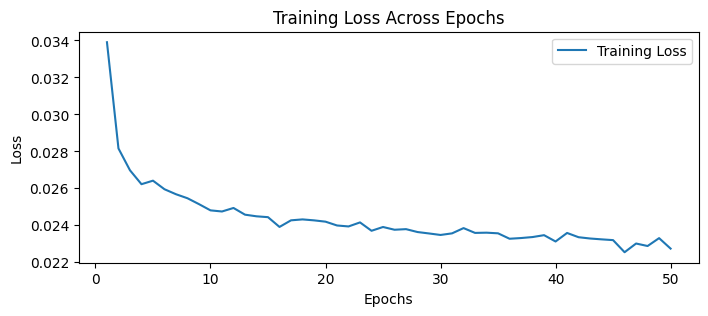

In [301]:
epochs = range(1, len(loss_across)+1)

plt.figure(figsize=(8,3))
plt.plot(epochs, loss_across, label='Training Loss')
plt.title('Training Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Results
References:
- https://matplotlib.org/stable/api/index.html
- Lab 02

In [326]:
# Checkpoint function
import json

def save_results(results, filename="results.json"):
    with open(filename, 'w') as f:
        json.dump(results, f)

def load_results(filename="results.json"):
    with open(filename, 'r') as f:
        return json.load(f)

In [ ]:
train_images, train_labels, test_images, test_labels = load_mnist('./dataset')

# Reshape and normalize
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

Here we will iterate through all combinations of the below parameters to then plot the various results and see what worked best and other interesting results. This took around 48 hours to compute with 32GB of RAM so I do not suggest running it.

In [332]:
# All parameters configurations that we will try out to plot afterwards
layers = [[128, 10], [256, 10], [256, 128, 10]]
activation_funcs = ["sigmoid", "relu"]
optimizers = [SGDOptimizer, SGDMomentumOptimizer]
momentums = [.4, .6, .8]
learning_rates = [.2, .5, .7]
batch_sizes = [15, 30, 45, 80]
dropout_probs = [0, .1, .2, .4]
epochs = 50

In [ ]:
results = []

for layer in layers:
    for activation_f in activation_funcs:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                for dropout_prob in dropout_probs:
                    for optimizer_f in optimizers:
                        if optimizer_f == SGDOptimizer:
                            print(f"[+] {activation_f} - LR: {learning_rate} - BS: {batch_size} - DP: {dropout_prob} - OP: SGD")
                            optimizer = SGDOptimizer(learning_rate=learning_rate)
                            nn = NeuralNet(activation_function=activation_f,
                                          neurons=layer,
                                          learning_rate=learning_rate,
                                          optimizer=optimizer,
                                          dropout_prob=dropout_prob)
                            loss_across = nn.train_network(epochs=epochs,
                                                           batch_size=batch_size,
                                                          X_train=train_images,
                                                          Y_train=train_labels)
                            accuracy, loss = nn.evaluate_model(test_images, test_labels)

                            results.append({
                                "activation": activation_f,
                                "optimizer": "SGDOptimizer",
                                "learning_rate": learning_rate,
                                "batch_size": batch_size,
                                "layer": layer,
                                "dropout_prob": dropout_prob,
                                "accuracy": accuracy,
                                "loss": loss,
                                "loss_across": loss_across,
                            })
                            save_results(results)
                        else:
                            for momentum in momentums:
                                print(f"[+] {activation_f} - LR: {learning_rate} - BS: {batch_size} - DP: {dropout_prob} - MO: {momentum}")
                                optimizer = SGDMomentumOptimizer(learning_rate=learning_rate, momentum=momentum)
                                nn = NeuralNet(activation_function=activation_f,
                                              neurons=layer,
                                              learning_rate=learning_rate,
                                              optimizer=optimizer,
                                              dropout_prob=dropout_prob)

                                loss_across = nn.train_network(epochs=epochs,
                                                               batch_size=batch_size,
                                                              X_train=train_images,
                                                              Y_train=train_labels)

                                accuracy, loss = nn.evaluate_model(test_images, test_labels)

                                results.append({
                                    "activation": activation_f,
                                    "optimizer": "SGDMomentumOptimizer",
                                    "momentum": momentum,
                                    "learning_rate": learning_rate,
                                    "batch_size": batch_size,
                                    "layer": layer,
                                    "dropout_prob": dropout_prob,
                                    "accuracy": accuracy,
                                    "loss": loss,
                                    "loss_across": loss_across,
                                })
                                save_results(results)

[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.1 - OP: SGD


/tmp/ipykernel_28317/3392490630.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.4 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.4 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.4 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.4 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.1 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.

[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.4 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.4 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.4 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.4 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.1 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.

[+] relu - LR: 0.7 - BS: 30 - DP: 0 - MO: 0.8
[+] relu - LR: 0.7 - BS: 30 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.7 - BS: 30 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.7 - BS: 30 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.7 - BS: 30 - DP: 0.1 - MO: 0.8
[+] relu - LR: 0.7 - BS: 30 - DP: 0.2 - OP: SGD
[+] relu - LR: 0.7 - BS: 30 - DP: 0.2 - MO: 0.4
[+] relu - LR: 0.7 - BS: 30 - DP: 0.2 - MO: 0.6
[+] relu - LR: 0.7 - BS: 30 - DP: 0.2 - MO: 0.8
[+] relu - LR: 0.7 - BS: 30 - DP: 0.4 - OP: SGD
[+] relu - LR: 0.7 - BS: 30 - DP: 0.4 - MO: 0.4
[+] relu - LR: 0.7 - BS: 30 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.7 - BS: 30 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.7 - BS: 45 - DP: 0 - OP: SGD
[+] relu - LR: 0.7 - BS: 45 - DP: 0 - MO: 0.4
[+] relu - LR: 0.7 - BS: 45 - DP: 0 - MO: 0.6
[+] relu - LR: 0.7 - BS: 45 - DP: 0 - MO: 0.8
[+] relu - LR: 0.7 - BS: 45 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.7 - BS: 45 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.7 - BS: 45 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.7 - BS: 45 - DP: 0.1 - MO: 0.8
[+

[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.4 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.4 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.4 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.4 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.1 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.

[+] relu - LR: 0.5 - BS: 45 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0.2 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0.2 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0.2 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0.2 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0.4 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0.4 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.5 - BS: 80 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 80 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 80 - DP: 0 - MO: 0.6
[+] relu - LR: 0.5 - BS: 80 - DP: 0 - MO: 0.8
[+] relu - LR: 0.5 - BS: 80 - DP: 0.1 - OP: SGD
[+] relu

[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.4 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.4 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.4 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.4 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.1 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.

[+] relu - LR: 0.2 - BS: 45 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.2 - BS: 45 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.2 - BS: 80 - DP: 0 - OP: SGD
[+] relu - LR: 0.2 - BS: 80 - DP: 0 - MO: 0.4
[+] relu - LR: 0.2 - BS: 80 - DP: 0 - MO: 0.6
[+] relu - LR: 0.2 - BS: 80 - DP: 0 - MO: 0.8
[+] relu - LR: 0.2 - BS: 80 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.2 - BS: 80 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.2 - BS: 80 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.2 - BS: 80 - DP: 0.1 - MO: 0.8
[+] relu - LR: 0.2 - BS: 80 - DP: 0.2 - OP: SGD
[+] relu - LR: 0.2 - BS: 80 - DP: 0.2 - MO: 0.4
[+] relu - LR: 0.2 - BS: 80 - DP: 0.2 - MO: 0.6
[+] relu - LR: 0.2 - BS: 80 - DP: 0.2 - MO: 0.8
[+] relu - LR: 0.2 - BS: 80 - DP: 0.4 - OP: SGD
[+] relu - LR: 0.2 - BS: 80 - DP: 0.4 - MO: 0.4
[+] relu - LR: 0.2 - BS: 80 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.2 - BS: 80 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.5 - BS: 15 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 15 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 15 - DP: 0 - MO: 0.6
[+] re

/tmp/ipykernel_28317/2957073901.py:68: RuntimeWarning: invalid value encountered in multiply
  A *= mask


[+] relu - LR: 0.5 - BS: 30 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.6
[+] relu - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.8
[+] relu - LR: 0.5 - BS: 30 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.8
[+] relu - LR: 0.5 - BS: 30 - DP: 0.2 - OP: SGD
[+] relu - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.4
[+] relu - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.6
[+] relu - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.8
[+] relu - LR: 0.5 - BS: 30 - DP: 0.4 - OP: SGD
[+] relu - LR: 0.5 - BS: 30 - DP: 0.4 - MO: 0.4
[+] relu - LR: 0.5 - BS: 30 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.5 - BS: 30 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - OP: SGD
[+] relu

In [ ]:
len(results)

1152

# Plotting Loss across epochs for each architecture

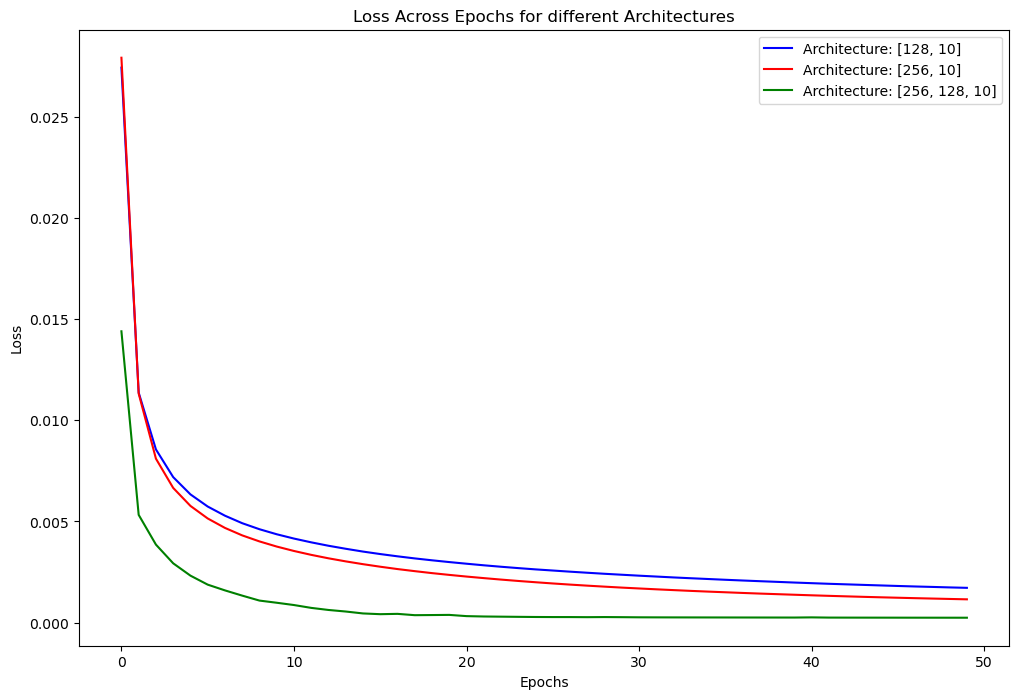

In [ ]:
plt.figure(figsize=(12, 8))
colours = ['blue', 'red', 'green']

for i, layer in enumerate(layers):
    # Find the entry with the highest accuracy for this architecture
    best_entry = max((item for item in results if item['layer'] == layer), key=lambda x: x['accuracy'])

    plt.plot(best_entry['loss_across'], label=f'Architecture: {layer}', color=colours[i])

    plt.title(f'Loss Across Epochs for different Architectures')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting impact of learning rate for activation/optimizer combinations

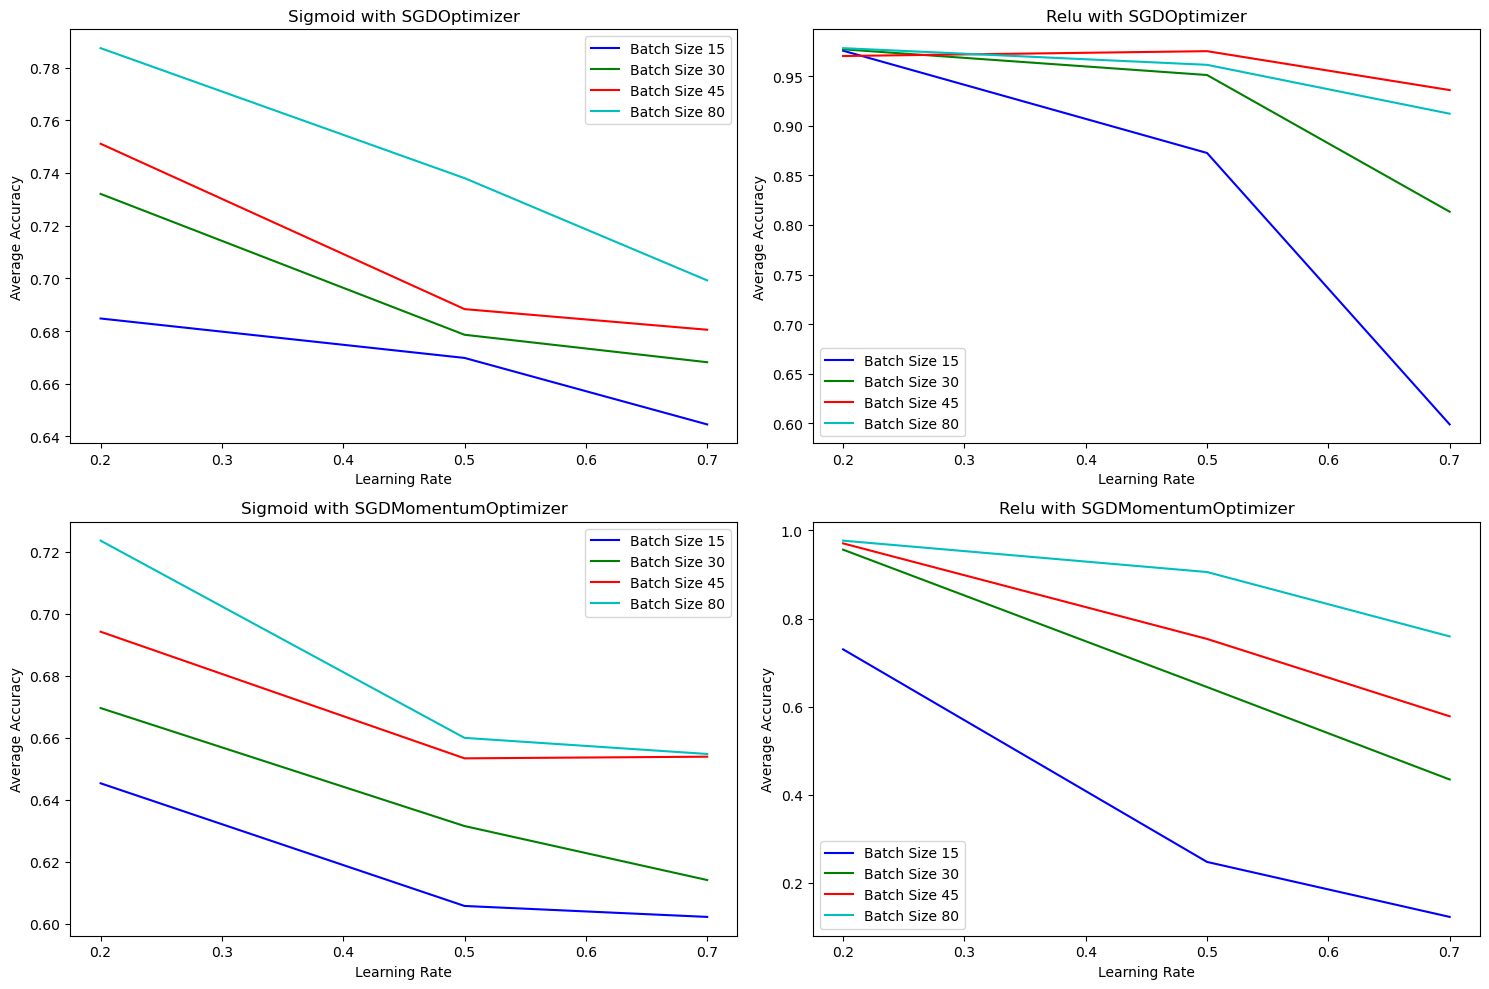

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
architecture = [256, 128, 10]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Titles for each subplot
titles = [
    "Sigmoid with SGDOptimizer",
    "Relu with SGDOptimizer",
    "Sigmoid with SGDMomentumOptimizer",
    "Relu with SGDMomentumOptimizer"
]

# Arrange the data and plots
for i, (activation, optimizer) in enumerate([
    ("sigmoid", "SGDOptimizer"),
    ("relu", "SGDOptimizer"),
    ("sigmoid", "SGDMomentumOptimizer"),
    ("relu", "SGDMomentumOptimizer")
]):
    ax = axes[i//2, i%2]  # Determine the correct subplot

    # Filter data for the specific activation function and optimizer
    filtered_data = [entry for entry in results if entry['activation'] == activation and entry['optimizer'] == optimizer]

    # Plot each batch size with different color
    for batch_size, color in zip(batch_sizes, colors):
        # Calculate average accuracy for each learning rate
        accuracies = []
        for lr in learning_rates:
            # Filter data for specific learning rate and batch size
            lr_data = [entry['accuracy'] for entry in filtered_data if entry['learning_rate'] == lr and entry['batch_size'] == batch_size]
            avg_accuracy = sum(lr_data) / len(lr_data) if lr_data else None  # Calculate average if data is available
            accuracies.append(avg_accuracy)

        # Plotting the line for each batch size
        ax.plot(learning_rates, accuracies, color=color, label=f'Batch Size {batch_size}')

    ax.set_title(titles[i])
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Average Accuracy')
    ax.legend()

plt.tight_layout()
plt.show()

# Plotting dropout impact for different architectures, separated by activation function

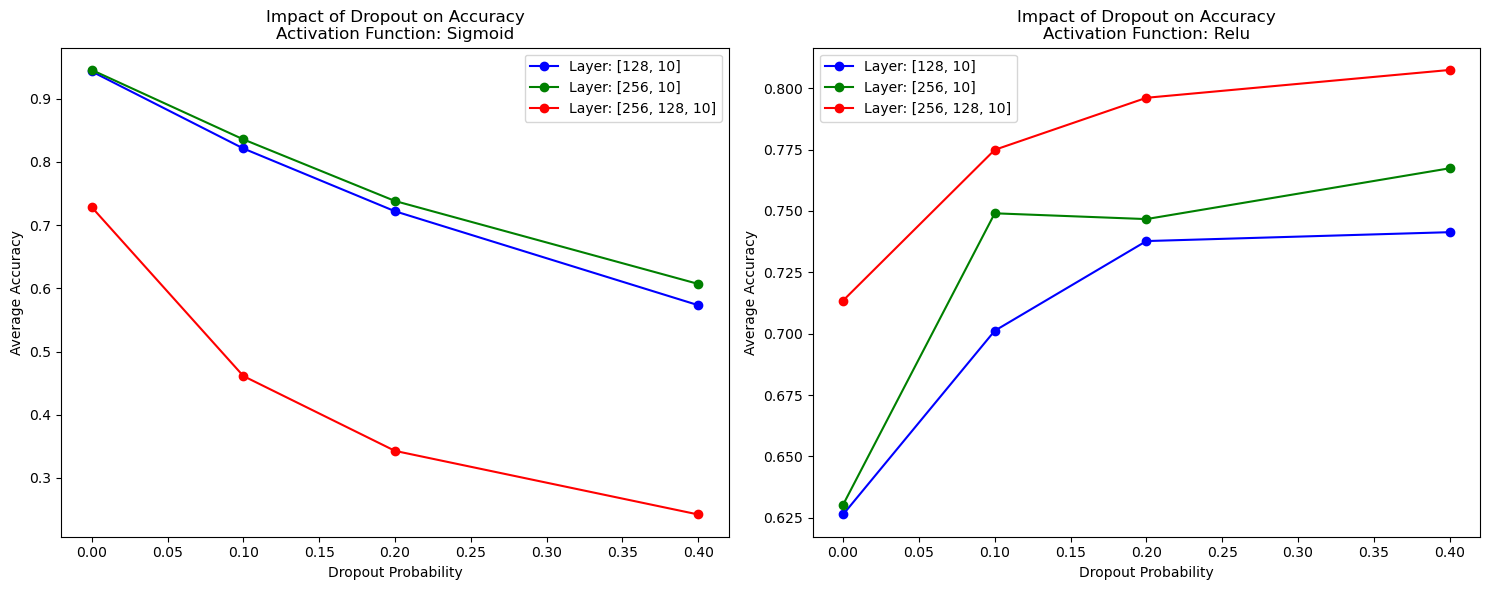

In [ ]:
colors = ['b', 'g', 'r']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns for sigmoid and relu

# Iterate through each activation function and plot
for idx, activation_f in enumerate(activation_funcs):
    ax = axes[idx]

    # For each layer architecture
    for layer, color in zip(layers, colors):
        accuracies = []

        # Collect accuracies for each dropout probability
        for dropout in dropout_probs:
            # Filter results for the specific combination
            layer_data = [entry for entry in results if entry['layer'] == layer and entry['activation'] == activation_f and entry['dropout_prob'] == dropout]
            avg_accuracy = sum([d['accuracy'] for d in layer_data]) / len(layer_data) if layer_data else None
            accuracies.append(avg_accuracy)

        # Plotting for each architecture
        ax.plot(dropout_probs, accuracies, color=color, marker='o', label=f'Layer: {layer}')

    ax.set_title(f'Impact of Dropout on Accuracy\nActivation Function: {activation_f.capitalize()}')
    ax.set_xlabel('Dropout Probability')
    ax.set_ylabel('Average Accuracy')
    ax.legend()

plt.tight_layout()
plt.show()

In [338]:
# Function to calculate average loss across multiple runs
def average_loss_across_runs(specific_results):
    # Get all loss arrays
    all_losses = np.array([res['loss_across'] for res in specific_results])
    # Calculate the mean across all runs
    avg_loss = np.mean(all_losses, axis=0)
    return avg_loss

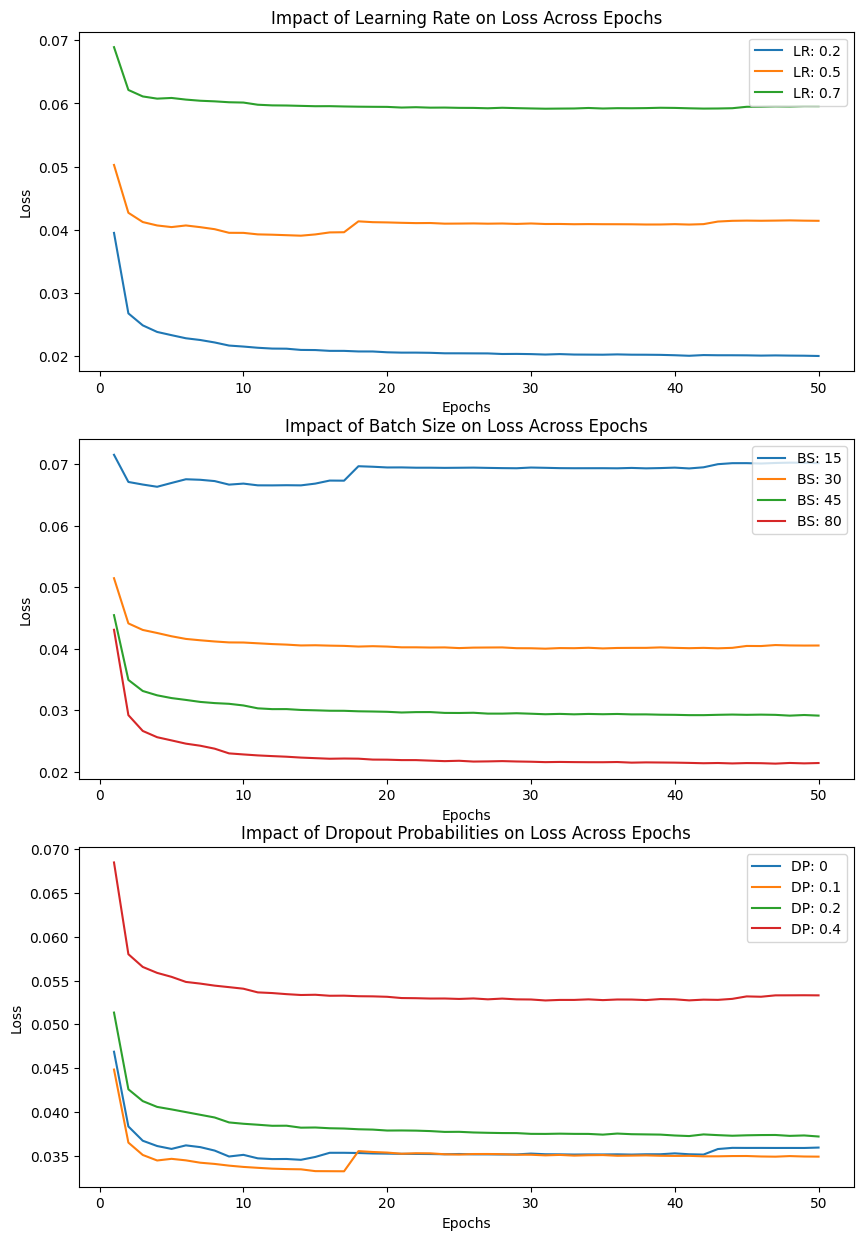

In [341]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for varying learning rates
for lr in learning_rates:
    specific_results = [r for r in results if r['activation'] == best_result['activation']
                        and r['optimizer'] == best_result['optimizer']
                        and r['momentum'] == best_result['momentum']
                        and r['layer'] == best_result['layer']
                        and r['learning_rate'] == lr]
    if specific_results:
        avg_loss_across = average_loss_across_runs(specific_results)
        axes[0].plot(range(1, len(avg_loss_across)+1), avg_loss_across, label=f'LR: {lr}')

axes[0].set_title('Impact of Learning Rate on Loss Across Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot for varying batch sizes
for bs in batch_sizes:
    specific_results = [r for r in results if r['activation'] == best_result['activation']
                        and r['optimizer'] == best_result['optimizer']
                        and r['momentum'] == best_result['momentum']
                        and r['layer'] == best_result['layer']
                        and r['batch_size'] == bs]
    if specific_results:
        avg_loss_across = average_loss_across_runs(specific_results)
        axes[1].plot(range(1, len(avg_loss_across)+1), avg_loss_across, label=f'BS: {bs}')

axes[1].set_title('Impact of Batch Size on Loss Across Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Plot for varying dropout probabilities
for dp in dropout_probs:
    specific_results = [r for r in results if r['activation'] == best_result['activation']
                        and r['optimizer'] == best_result['optimizer']
                        and r['momentum'] == best_result['momentum']
                        and r['layer'] == best_result['layer']
                        and r['dropout_prob'] == dp]
    if specific_results:
        avg_loss_across = average_loss_across_runs(specific_results)
        axes[2].plot(range(1, len(avg_loss_across)+1), avg_loss_across, label=f'DP: {dp}')

axes[2].set_title('Impact of Dropout Probabilities on Loss Across Epochs')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Loss')
axes[2].legend()

# Taking a look at our 'best' result and its configuration

In [327]:
results = load_results()

In [342]:
accuracies = [i['accuracy'] for i in results]

In [343]:
# Our best result across the board
best_result = [re for re in results if re['accuracy'] == max(accuracies)][0]

In [345]:
best_result

{'activation': 'relu',
 'optimizer': 'SGDMomentumOptimizer',
 'momentum': 0.6,
 'learning_rate': 0.5,
 'batch_size': 45,
 'layer': [256, 128, 10],
 'dropout_prob': 0,
 'accuracy': 0.9858,
 'loss': 0.002780826218288223,
 'loss_across': [0.014405494777687102,
  0.0053263236577529936,
  0.0038552118788943894,
  0.0029301502456128303,
  0.0023201844806740495,
  0.0018755845695625282,
  0.0015907767144778759,
  0.0013323551699570286,
  0.0010867660570402342,
  0.0009796903900065725,
  0.0008662094041064235,
  0.0007255670113295868,
  0.0006226301547266212,
  0.0005457292834077984,
  0.00045067427836683693,
  0.00041404332060183496,
  0.00043004016654067624,
  0.00036474923926815915,
  0.00037126894530133776,
  0.00037873391021233673,
  0.0003181119111929249,
  0.0002998006439637034,
  0.000290996920738343,
  0.0002827005227520857,
  0.0002753303354642801,
  0.00027152851558835987,
  0.00027095678303912376,
  0.00026637286913308616,
  0.0002715131557211232,
  0.0002662285788145819,
  0.00025

# Demonstration of our 'strongest' configuration with seed

In [344]:
np.random.seed(31415)

In [346]:
train_images, train_labels, test_images, test_labels = load_mnist('./dataset')

# Reshape and normalize
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

learning_rate = 0.5
optimizer = SGDMomentumOptimizer(learning_rate=learning_rate, momentum=0.6)

# Create an instance of NeuralNet
nn = NeuralNet(activation_function='relu', neurons=[256, 128, 10], learning_rate=learning_rate, optimizer=optimizer, dropout_prob=0)

# Train the network
loss_across = nn.train_network(epochs=50, batch_size=45, X_train=train_images, Y_train=train_labels)

accuracy, loss = nn.evaluate_model(test_images, test_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss}")

Epoch 1/50, Loss: 0.015010194577403303
Epoch 2/50, Loss: 0.00538919363172571
Epoch 3/50, Loss: 0.0038060114899221716
Epoch 4/50, Loss: 0.002981839985524173
Epoch 5/50, Loss: 0.0023220988595752954
Epoch 6/50, Loss: 0.0019225727967120286
Epoch 7/50, Loss: 0.0015735827778019938
Epoch 8/50, Loss: 0.001325988876294501
Epoch 9/50, Loss: 0.0011224122021368152
Epoch 10/50, Loss: 0.0009541293843486546
Epoch 11/50, Loss: 0.0008647151696519236
Epoch 12/50, Loss: 0.0007140833629687893
Epoch 13/50, Loss: 0.0006404686179473753
Epoch 14/50, Loss: 0.0005340527116229235
Epoch 15/50, Loss: 0.00047090112008215214
Epoch 16/50, Loss: 0.00042594176464794885
Epoch 17/50, Loss: 0.0003771006401045921
Epoch 18/50, Loss: 0.00036983290167944867
Epoch 19/50, Loss: 0.000336334974034136
Epoch 20/50, Loss: 0.00031255390775191387
Epoch 21/50, Loss: 0.000294915434286711
Epoch 22/50, Loss: 0.0002882188300587984
Epoch 23/50, Loss: 0.00028005595054541525
Epoch 24/50, Loss: 0.0002750256944385325
Epoch 25/50, Loss: 0.000271

# Task 2

In [2]:
# Import required libraries
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import glob,os
import matplotlib.image as mpimg
from datetime import datetime

In [3]:
# Seed for reproducibility
torch.manual_seed(3063)

In [4]:
#Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device:",device)

Device: cpu


In [307]:
dataset_root = './dataset/chest_xray/'

In [6]:
# Dataset that Aymen run seperately from my local machine 
dataset_root = '/Users/aymensaid/Documents/dataset/chest_xray'

### Loading Data
> Note: We apply transforms.Grayscale since these are x-rays and we do not need the RGB.

In [7]:
labels = ['NORMAL', 'PNEUMONIA']
image_dims = (120, 120)

train_dir = os.path.join(dataset_root, 'train')
test_dir = os.path.join(dataset_root, 'test')
val_dir = os.path.join(dataset_root, 'val')

train_data = ImageFolder(train_dir, transform=transforms.Compose([
    transforms.Resize(image_dims), 
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor()
]))
test_data = ImageFolder(test_dir, transform=transforms.Compose([
    transforms.Resize(image_dims), 
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor()
]))
val_data = ImageFolder(val_dir, transform=transforms.Compose([
    transforms.Resize(image_dims), 
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor()
]))

In [8]:
img, label = train_data[0]
print(img.shape,label)
print("Classes: ", train_data.classes)

torch.Size([1, 120, 120]) 0
Classes:  ['NORMAL', 'PNEUMONIA']


## Example image

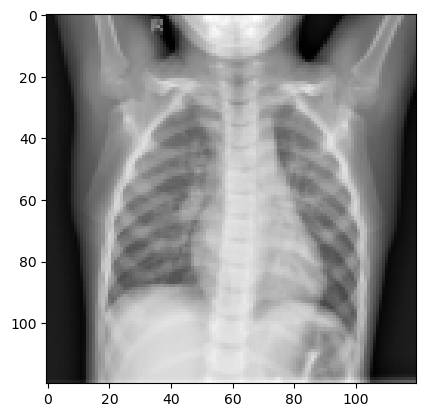

In [9]:
# Squeeze reduces tensore to heigh,width, cmap=gray since grayscaled.
plt.imshow(img.squeeze(), cmap='gray')

In [10]:
# Load training data
# Double the batch size for val and test, as we don't have backpropagation (more efficient)
batch_size = 128
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size*2, num_workers=4, pin_memory=True)

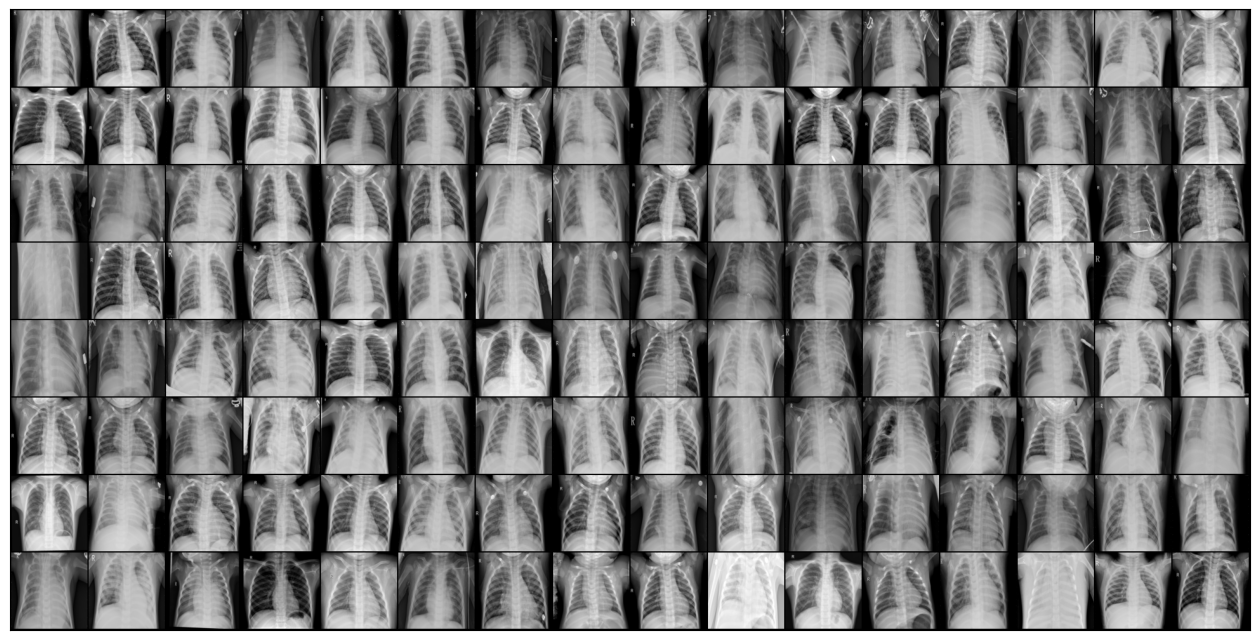

In [11]:
# Reference: Taken verbatim from Lab 9.4
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

## Base Model Definition
- Ref: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html#convolutional-layers


In [12]:
class XrayClassification(nn.Module):
    def __init__(self):
        super(XrayClassification, self).__init__()
        self.network = nn.Sequential(
            # Initial feature extraction
            nn.Conv2d(1, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),

            # Increasing depth to capture more complex features
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, stride=2, padding=1),

            # Doubling depth to capture more abstract and complex features
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, stride=2, padding=1),

            # Doubling depth again 
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, stride=2, padding=1),
            
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, stride=2, padding=1),
            
            nn.Flatten(),
            
            nn.Linear(6400, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [13]:
xc = XrayClassification()
print(xc)

XrayClassification(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): 

In [14]:
# We use the accuracy, evaluate, and fit method from IN3063 Lab 9.4, with only slight modifications
# Also used PyTorch docs for reference here: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation

def accuracy(outputs, labels):
    preds = outputs.round()  # Convert probabilities to 0 or 1
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# no_grad ensures no gradients are computed
@torch.no_grad()
def evaluate(model, val_loader, device):
    model.eval()
    outputs = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        # Get prediction and loss & accuracy
        out = model(images)
        loss = F.binary_cross_entropy(out.squeeze(), labels.type_as(out))
        acc = accuracy(out.squeeze(), labels)  # Squeeze to remove channel dimension
        outputs.append({'val_loss': loss.item(), 'val_acc': acc})
    
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.mean(torch.tensor(batch_losses))  # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.mean(torch.tensor(batch_accs))  # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, device=None):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        start = datetime.now()
        model.train()
        train_losses = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # Compute Prediction and get Loss
            out = model(images)
            loss = F.binary_cross_entropy(out.squeeze(), labels.type_as(out))
            train_losses.append(loss.item())
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader, device)
        result['train_loss'] = torch.mean(torch.tensor(train_losses)).item()
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
        print(f"Time taken for epoch {epoch}: {datetime.now()-start}")
        history.append(result)
    return history

In [316]:
xc.to(device)

num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, xc, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.3368, val_loss: 3.6626, val_acc: 0.5000
Time taken for epoch 0: 0:01:21.904359
Epoch [1], train_loss: 0.1294, val_loss: 1.6831, val_acc: 0.5000
Time taken for epoch 1: 0:01:22.360298
Epoch [2], train_loss: 0.0864, val_loss: 1.9061, val_acc: 0.5000
Time taken for epoch 2: 0:01:23.927975
Epoch [3], train_loss: 0.0755, val_loss: 2.6360, val_acc: 0.5000
Time taken for epoch 3: 0:01:23.821765
Epoch [4], train_loss: 0.0595, val_loss: 2.4093, val_acc: 0.5000
Time taken for epoch 4: 0:01:22.704077
Epoch [5], train_loss: 0.0437, val_loss: 2.9708, val_acc: 0.5000
Time taken for epoch 5: 0:01:20.656098
Epoch [6], train_loss: 0.0415, val_loss: 2.1242, val_acc: 0.5000
Time taken for epoch 6: 0:01:25.157408
Epoch [7], train_loss: 0.0415, val_loss: 0.5924, val_acc: 0.8125
Time taken for epoch 7: 0:01:19.208091
Epoch [8], train_loss: 0.0344, val_loss: 2.5513, val_acc: 0.5000
Time taken for epoch 8: 0:01:24.977556
Epoch [9], train_loss: 0.0254, val_loss: 3.1876, val_acc: 0.5000

In [317]:
# Evaluate on test data
test_results = evaluate(xc, test_dl, None)
print(f'Test Loss: {test_results["val_loss"]}, Test Accuracy: {test_results["val_acc"]}')

Test Loss: 3.047215461730957, Test Accuracy: 0.6966145634651184


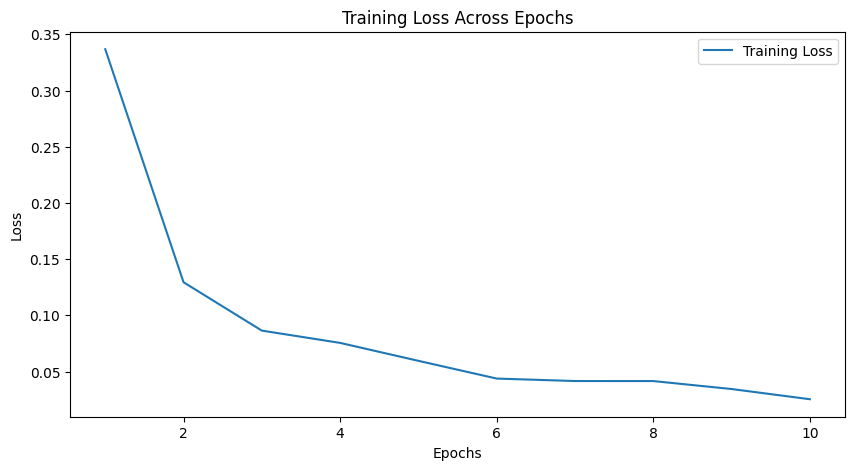

In [318]:
train_losses = [x['train_loss'] for x in history]
epochs = range(1, len(history)+1)

plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.title('Training Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.c Improvements

We replaced the last convolutional layer (256,256) with a convolutional layer in the middle of the network, which also preserves the input size (64,64). It is not followed by a dropout. For further reference see section 2.c of the report. 

In [15]:
xc = XrayClassification()

xc.network = nn.Sequential(
            # Initial feature extraction
            nn.Conv2d(1, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),

            # Increasing depth to capture more complex features
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(2, stride=2, padding=1),

            # Maintaining depth to refine/combine features before moving on
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # No dropout at this layer
            nn.MaxPool2d(2, stride=2, padding=1),

            # Doubling depth to capture more abstract and complex features
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, stride=2, padding=1),

            # Doubling depth again 
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, stride=2, padding=1),
            
            nn.Flatten(),
            
            nn.Linear(6400, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

print(xc)

XrayClassification(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, a

In [320]:
# Load training data
batch_size = 128
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size*2, num_workers=4, pin_memory=True)

xc.to(device)

# Same parameters
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, xc, train_dl, val_dl, opt_func)

# Evaluate on test data
test_results = evaluate(xc, test_dl, None)
print(f'Test Loss: {test_results["val_loss"]}, Test Accuracy: {test_results["val_acc"]}')

Epoch [0], train_loss: 0.3930, val_loss: 3.2910, val_acc: 0.5000
Time taken for epoch 0: 0:01:05.497665
Epoch [1], train_loss: 0.1445, val_loss: 1.3921, val_acc: 0.5000
Time taken for epoch 1: 0:01:05.179929
Epoch [2], train_loss: 0.1020, val_loss: 1.4386, val_acc: 0.6250
Time taken for epoch 2: 0:01:04.708917
Epoch [3], train_loss: 0.0871, val_loss: 1.7208, val_acc: 0.5000
Time taken for epoch 3: 0:01:02.135513
Epoch [4], train_loss: 0.0596, val_loss: 0.5258, val_acc: 0.7500
Time taken for epoch 4: 0:01:01.681421
Epoch [5], train_loss: 0.0581, val_loss: 1.1457, val_acc: 0.5625
Time taken for epoch 5: 0:01:04.882095
Epoch [6], train_loss: 0.0477, val_loss: 0.3052, val_acc: 0.8750
Time taken for epoch 6: 0:01:02.446170
Epoch [7], train_loss: 0.0327, val_loss: 0.1528, val_acc: 1.0000
Time taken for epoch 7: 0:01:00.057767
Epoch [8], train_loss: 0.0437, val_loss: 0.1629, val_acc: 0.9375
Time taken for epoch 8: 0:01:00.343649
Epoch [9], train_loss: 0.0382, val_loss: 1.2053, val_acc: 0.5625

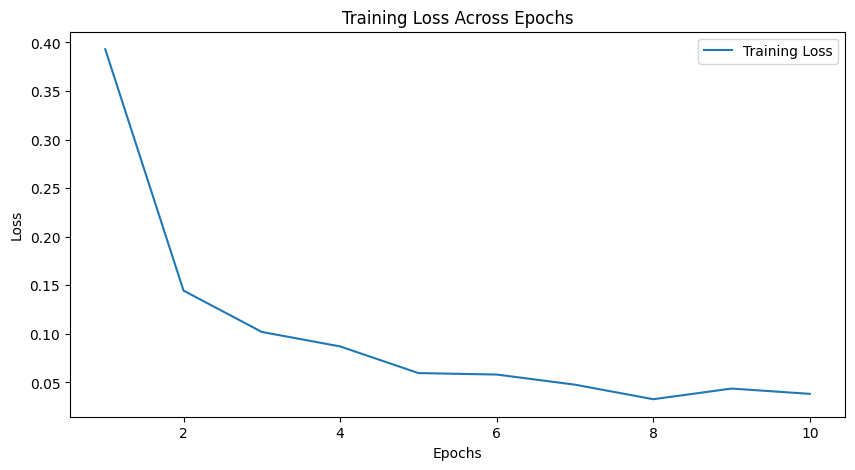

In [321]:
train_losses = [x['train_loss'] for x in history]
epochs = range(1, len(history)+1)

plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.title('Training Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.d Model optimisation
- Plan to either use 'grid search' or 'random search' to optimise hyperparameters
- Reference: https://machinelearningmastery.com/how-to-grid-search-hyperparameters-for-pytorch-models/ (grid search)

In [19]:
# Plan to either use 'grid search' or 'random search' to optimise hyperparameters

## GRID SEARCH 
from sklearn.model_selection import GridSearchCV

# define grid search parameters
param_grid = {
    'batch_size': [32, 64, 128],
    'max_epochs': [5, 10, 15]
}

grid = GridSearchCV(estimator=xc, param_grid=param_grid, scoring='accuracy', cv=3)
grid_result = grid.fit(train_dataset, train_labels)

# Print the best hyperparameters
print("Best hyperparameters:", grid_reseult.best_params_)

# Train the model with the best hyperparameters
best_model = grid_result.best_estimator_
accuracy = train_and_evaluate(best_model, train_dataset, test_dataset, criterion, optimizer, epochs=grid_search.best_params_['epochs'])

print("Final accuracy on the test set:", accuracy)

NameError: name 'X' is not defined